In [3]:
!pip install -q "transformers>=4.40.0" "datasets" "accelerate" "bitsandbytes" "peft" "evaluate"

In [4]:
from datasets import load_dataset
import random

train_ds = load_dataset("json", data_files="/content/general_train.json")["train"]
val_ds   = load_dataset("json", data_files="/content/general_val.json")["train"]

SYSTEM_PROMPTS = [
    "You are a helpful, knowledgeable AI assistant with expertise across multiple domains. You provide clear, accurate, and thoughtful responses.",
    "You are an intelligent assistant that helps users learn and understand complex topics. You explain things clearly and adapt to the user's level.",
    "You are a versatile AI tutor and assistant. You break down complex concepts, provide examples, and ensure understanding.",
    "You are a friendly and knowledgeable AI that helps users with questions across various subjects. You're patient, thorough, and encouraging."
]

INSTRUCTION_TEMPLATES = {
    # Question-style templates
    "question": [
        "### Question:\n{instruction}\n\n### Response:",
        "User asked: {instruction}\n\nLet me help you with that:",
        "**Question:** {instruction}\n\n**Answer:**",
        "Q: {instruction}\n\nA:",
    ],

    # Explanation-style templates
    "explanation": [
        "### Task:\n{instruction}\n\n### Explanation:",
        "**Request:** {instruction}\n\n**Response:**",
        "The user wants to know: {instruction}\n\nHere's a comprehensive explanation:",
    ],

    # Instruction-style templates
    "instruction": [
        "### Instruction:\n{instruction}\n\n### Solution:",
        "**Task:** {instruction}\n\n**Answer:**",
        "User request: {instruction}\n\nResponse:",
    ],

    # Conversational templates
    "conversational": [
        "Human: {instruction}\n\nAssistant:",
        "User: {instruction}\n\nAI:",
        "<|user|>\n{instruction}\n\n<|assistant|>",
    ],

    # With-context templates (for items with input field)
    "with_context": [
        "### Instruction:\n{instruction}\n\n### Context:\n{input}\n\n### Response:",
        "**Question:** {instruction}\n\n**Additional Information:**\n{input}\n\n**Answer:**",
        "Given the following context:\n{input}\n\n{instruction}\n\nResponse:",
        "User query: {instruction}\n\nContext: {input}\n\nAnswer:",
    ]
}

def get_source_category(source):
    """Categorize data source to select appropriate template style"""
    if not source:
        return "conversational"

    source_lower = source.lower()

    if "stack" in source_lower or "programming" in source_lower:
        return "question"  # Technical Q&A
    elif "arxiv" in source_lower or "paper" in source_lower:
        return "explanation"  # Academic content
    elif "wikipedia" in source_lower or "gutenberg" in source_lower:
        return "explanation"  # Encyclopedic or literary
    elif "common_crawl" in source_lower or "web" in source_lower:
        return "conversational"  # General web content
    else:
        return "conversational"

def format_example_advanced(ex, use_system_prompt=True, vary_templates=True):
    """
    Advanced formatting with:
    - System prompts
    - Multiple template variations
    - Source-aware formatting
    - Better conversation flow
    """

    # Select system prompt
    system_prompt = random.choice(SYSTEM_PROMPTS) if use_system_prompt else ""

    # Get source category
    source = ex.get("source", "")
    category = get_source_category(source)

    # Handle context/input field
    has_input = ex.get("input") and len(ex.get("input", "").strip()) > 0

    if has_input:
        # Use context-aware templates
        if vary_templates:
            template = random.choice(INSTRUCTION_TEMPLATES["with_context"])
        else:
            template = INSTRUCTION_TEMPLATES["with_context"][0]

        prompt_body = template.format(
            instruction=ex["instruction"].strip(),
            input=ex["input"].strip()
        )
    else:
        # Use regular templates based on source category
        if vary_templates:
            template = random.choice(INSTRUCTION_TEMPLATES[category])
        else:
            template = INSTRUCTION_TEMPLATES[category][0]

        prompt_body = template.format(instruction=ex["instruction"].strip())

    # Combine system prompt and body
    if system_prompt:
        full_prompt = f"{system_prompt}\n\n{prompt_body}"
    else:
        full_prompt = prompt_body

    return {
        "prompt": full_prompt,
        "output": ex["output"].strip(),
        "source": source,
        "category": category
    }

def format_example_chat_style(ex):
    """
    ChatML-style formatting (similar to ChatGPT/GPT-4 training format)
    This is excellent for conversational models
    """
    has_input = ex.get("input") and len(ex.get("input", "").strip()) > 0

    # Build the user message
    if has_input:
        user_message = f"{ex['instruction'].strip()}\n\nAdditional context: {ex['input'].strip()}"
    else:
        user_message = ex['instruction'].strip()

    # ChatML format
    chat_prompt = (
        "<|im_start|>system\n"
        "You are a helpful, knowledgeable AI assistant that provides accurate and thoughtful responses across various topics.<|im_end|>\n"
        "<|im_start|>user\n"
        f"{user_message}<|im_end|>\n"
        "<|im_start|>assistant\n"
    )

    return {
        "prompt": chat_prompt,
        "output": ex["output"].strip() + "<|im_end|>",
        "source": ex.get("source", "")
    }

def format_example_llama_style(ex):
    """
    Llama-2/3 style formatting with [INST] tags
    Great for Llama-based models
    """
    has_input = ex.get("input") and len(ex.get("input", "").strip()) > 0

    # Build instruction
    if has_input:
        instruction_text = f"{ex['instruction'].strip()}\n\nContext: {ex['input'].strip()}"
    else:
        instruction_text = ex['instruction'].strip()

    # Llama format with system prompt
    system_prompt = "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible."

    llama_prompt = (
        f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n"
        f"{instruction_text} [/INST]"
    )

    return {
        "prompt": llama_prompt,
        "output": ex["output"].strip() + "</s>",
        "source": ex.get("source", "")
    }


# Advanced varied templates
print("Applying advanced varied formatting...")
train_ds = train_ds.map(lambda ex: format_example_advanced(ex, use_system_prompt=True, vary_templates=True))
val_ds   = val_ds.map(lambda ex: format_example_advanced(ex, use_system_prompt=True, vary_templates=True))

print("\n" + "="*60)
print("SAMPLE FORMATTED EXAMPLES")
print("="*60)

for i in range(min(3, len(train_ds))):
    example = train_ds[i]
    print(f"\n--- Example {i+1} ---")
    print(f"Source: {example.get('source', 'N/A')}")
    print(f"Category: {example.get('category', 'N/A')}")
    print(f"\nPrompt:\n{example['prompt'][:500]}...")
    print(f"\nOutput:\n{example['output'][:300]}...")
    print("-" * 60)

print(f"\nTotal training examples: {len(train_ds)}")
print(f"Total validation examples: {len(val_ds)}")


Applying advanced varied formatting...

SAMPLE FORMATTED EXAMPLES

--- Example 1 ---
Source: arxiv
Category: explanation

Prompt:
You are a helpful, knowledgeable AI assistant with expertise across multiple domains. You provide clear, accurate, and thoughtful responses.

**Question:** What is the main contribution of this paper: Heuristic rule for constructing physics axiomatization

**Additional Information:**
Constructing the Theory of Everything (TOE) is an elusive goal of today's physics. Goedel's incompleteness theorem seems to forbid physics axiomatization, a necessary part of the TOE. The purpose of this contributio...

Output:
e. This will open up new roads into constructing the ultimate theory of everything. Three physical principles will be identified from the heuristic rule and they in turn will generate uniqueness results of various technical strengths regarding space, time, non-relativistic and relativistic quantum m...
-----------------------------------------------------

# Generic QLoRA finetune function

In [5]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    Trainer,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [6]:
def finetune_q_lora(
    base_model_name: str,
    output_dir: str,
    num_train_epochs: int = 2,
    lr: float = 2e-4,
    per_device_train_batch_size: int = 2,
    gradient_accumulation_steps: int = 16,
    max_seq_len: int = 512,
):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    print(f"Loading base model: {base_model_name}")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        quantization_config=bnb_config,
        device_map="auto",
    )
    tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    def tokenize_fn(batch):
        texts = []
        for p, o in zip(batch["prompt"], batch["output"]):
            texts.append(p + "\n" + o)
        enc = tokenizer(
            texts,
            truncation=True,
            max_length=max_seq_len,
            padding="max_length",
        )
        enc["labels"] = enc["input_ids"].copy()
        return enc

    tokenized_train = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
    tokenized_val   = val_ds.map(tokenize_fn, batched=True, remove_columns=val_ds.column_names)

    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=lr,
        weight_decay=0.01,
        logging_steps=20,
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
    )

    trainer.train()
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Saved LoRA-finetuned model to {output_dir}")

## LLaMA-3 8B Instruct

In [7]:
!pip install -U bitsandbytes

In [1]:
from huggingface_hub import login
login()

In [8]:
finetune_q_lora(
    base_model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    output_dir="/content/drive/MyDrive/Datascience_Tutor/new_Models/llama3-8b-ds-lora",
    num_train_epochs=2,
    lr=1.5e-4,
)

Loading base model: meta-llama/Meta-Llama-3-8B-Instruct


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


Map:   0%|          | 0/2095 [00:00<?, ? examples/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dpanchal1 (dpanchal1-stevens-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,2.050300
40,1.779800
60,1.721800
80,1.621900
100,1.533200
120,1.485900


Saved LoRA-finetuned model to /content/drive/MyDrive/Datascience_Tutor/new_Models/llama3-8b-ds-lora


## Mistral 7B Instruct

In [9]:
finetune_q_lora(
    base_model_name="mistralai/Mistral-7B-Instruct-v0.2",
    output_dir="/content/drive/MyDrive/Datascience_Tutor/new_Models/mistral-7b-ds-lora",
    num_train_epochs=2,
    lr=2e-4,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    max_seq_len=512,
)


Loading base model: mistralai/Mistral-7B-Instruct-v0.2


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

trainable params: 41,943,040 || all params: 7,283,675,136 || trainable%: 0.5758


Map:   0%|          | 0/2095 [00:00<?, ? examples/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,1.763800
40,1.529200
60,1.461600
80,1.211800
100,1.068400
120,1.009000


Saved LoRA-finetuned model to /content/mistral-7b-ds-lora


## Phi-3-mini-4k

In [10]:
finetune_q_lora(
    base_model_name="microsoft/Phi-3-mini-4k-instruct",
    output_dir="/content/drive/MyDrive/Datascience_Tutor/new_Models/phi3-mini-ds-lora",
    num_train_epochs=2,
    lr=1.5e-4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    max_seq_len=512,
)

Loading base model: microsoft/Phi-3-mini-4k-instruct


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327


Map:   0%|          | 0/2095 [00:00<?, ? examples/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,2.015800
40,1.711100
60,1.641700
80,1.613200
100,1.604300
120,1.588600


Saved LoRA-finetuned model to /content/drive/MyDrive/Datascience_Tutor/new_Models/phi3-mini-ds-lora


## Test

Following the LLaMA paper, we evaluate our models under 0-shot and few-shot prompting. In the k-shot setting, we prepend k example instruction–answer pairs from the training set as demonstrations before asking the model to answer a new test question.

We’ll do k ∈ {0, 1, 5} (you can change if you like).

### load datasets

In [20]:
import json, random

with open("/content/general_train.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open("/content/general_test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

len(train_data), len(test_data)

(2095, 259)

In [13]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=fa8a9a004ffc8ff2170931feb15a16c90e2d38c2ccfad16fa74e76d0ad0a9791
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [11]:
!pip install bert_score evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00


In [21]:
import json
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bert_score
import evaluate

rouge = evaluate.load("rouge")

## Prompt Builder

In [22]:
import random
from typing import List, Dict, Optional

# =======================
# ENHANCED SYSTEM PROMPTS
# =======================

TUTOR_PERSONAS = [
    {
        "name": "Friendly Expert",
        "prompt": (
            "You are an enthusiastic and knowledgeable data science tutor who loves helping students learn. "
            "You explain concepts clearly, use real-world examples, and encourage curiosity. "
            "You break down complex topics into digestible pieces and always check for understanding."
        )
    },
    {
        "name": "Patient Mentor",
        "prompt": (
            "You are a patient and supportive data science mentor with years of teaching experience. "
            "You understand that learning data science can be challenging, so you provide step-by-step explanations, "
            "relate concepts to everyday situations, and celebrate progress. You never make students feel inadequate."
        )
    },
    {
        "name": "Practical Guide",
        "prompt": (
            "You are a practical data science tutor focused on real-world applications. "
            "You connect theory to practice, share industry insights, and help students understand "
            "not just the 'how' but the 'why' and 'when' of different techniques."
        )
    },
    {
        "name": "Interactive Teacher",
        "prompt": (
            "You are an interactive data science tutor who engages students through examples and analogies. "
            "You make learning enjoyable by using relatable comparisons, visual descriptions, and practical scenarios. "
            "You adapt your teaching style to match the complexity of each question."
        )
    }
]

# =======================
# CONVERSATIONAL TEMPLATES
# =======================

def get_conversational_intro():
    """Returns a warm, conversational introduction"""
    intros = [
        "Great question! Let me help you understand this.",
        "I'm excited to explain this to you!",
        "This is an interesting topic! Here's what you need to know:",
        "Let me break this down for you in a clear way.",
        "Excellent question! Let me guide you through this.",
        "I'd be happy to help you with this!",
    ]
    return random.choice(intros)

def format_few_shot_example(example: Dict, index: int) -> str:
    """Format a single few-shot example in a conversational way"""

    # Vary the presentation style
    styles = [
        # Style 1: Clean Q&A
        lambda: (
            f"📚 Example {index}:\n"
            f"Student asks: \"{example['instruction']}\"\n"
            + (f"Context: {example['input']}\n" if example.get('input') else "")
            + f"Tutor explains: {example['output']}\n"
        ),

        # Style 2: Conversational
        lambda: (
            f"💬 Previous Question #{index}:\n"
            f"Q: {example['instruction']}\n"
            + (f"Additional info: {example['input']}\n" if example.get('input') else "")
            + f"A: {example['output']}\n"
        ),

        # Style 3: Simple and clear
        lambda: (
            f"Example {index}:\n"
            f"Question: {example['instruction']}\n"
            + (f"Given: {example['input']}\n" if example.get('input') else "")
            + f"Answer: {example['output']}\n"
        )
    ]

    return random.choice(styles)()

# =======================
# MAIN PROMPT BUILDERS
# =======================

def build_prompt_enhanced(
    example: Dict,
    shots: Optional[List[Dict]] = None,
    persona: str = "Friendly Expert",
    style: str = "conversational",
    include_emojis: bool = True
) -> str:
    """
    Enhanced prompt builder with multiple styles and personalities

    Args:
        example: Current question dict with 'instruction', 'input', 'output'
        shots: List of few-shot examples (optional)
        persona: Tutor personality ("Friendly Expert", "Patient Mentor", etc.)
        style: Prompt style ("conversational", "professional", "casual")
        include_emojis: Whether to include emoji indicators
    """

    # Select persona
    persona_dict = next((p for p in TUTOR_PERSONAS if p["name"] == persona), TUTOR_PERSONAS[0])
    system_prompt = persona_dict["prompt"]

    # Build the prompt based on style
    if style == "conversational":
        return _build_conversational_prompt(example, shots, system_prompt, include_emojis)
    elif style == "professional":
        return _build_professional_prompt(example, shots, system_prompt)
    elif style == "casual":
        return _build_casual_prompt(example, shots, system_prompt, include_emojis)
    else:
        return _build_conversational_prompt(example, shots, system_prompt, include_emojis)

def _build_conversational_prompt(
    example: Dict,
    shots: Optional[List[Dict]],
    system_prompt: str,
    include_emojis: bool
) -> str:
    """Warm, engaging conversational style"""

    emoji_thinking = "🤔 " if include_emojis else ""
    emoji_answer = "💡 " if include_emojis else ""

    prompt = f"{system_prompt}\n\n"
    prompt += "═" * 60 + "\n\n"

    # Few-shot examples
    if shots:
        prompt += f"Here are some examples of how I help students:\n\n"
        for i, shot in enumerate(shots, 1):
            prompt += format_few_shot_example(shot, i)
            prompt += "\n" + "─" * 60 + "\n\n"

    # Current question
    prompt += f"{emoji_thinking}**Your Question:**\n"
    prompt += f"{example['instruction']}\n\n"

    if example.get('input') and example['input'].strip():
        prompt += f"**Additional Context:**\n"
        prompt += f"{example['input']}\n\n"

    prompt += f"{emoji_answer}**My Answer:**\n"

    return prompt

def _build_professional_prompt(
    example: Dict,
    shots: Optional[List[Dict]],
    system_prompt: str
) -> str:
    """Clean, professional academic style"""

    prompt = f"### System\n{system_prompt}\n\n"

    # Few-shot examples
    if shots:
        prompt += "### Training Examples\n\n"
        for i, shot in enumerate(shots, 1):
            prompt += f"**Example {i}:**\n"
            prompt += f"Query: {shot['instruction']}\n"
            if shot.get('input'):
                prompt += f"Context: {shot['input']}\n"
            prompt += f"Response: {shot['output']}\n\n"

    # Current question
    prompt += "### Current Query\n\n"
    prompt += f"**Question:** {example['instruction']}\n\n"

    if example.get('input') and example['input'].strip():
        prompt += f"**Context:** {example['input']}\n\n"

    prompt += "**Response:**\n"

    return prompt

def _build_casual_prompt(
    example: Dict,
    shots: Optional[List[Dict]],
    system_prompt: str,
    include_emojis: bool
) -> str:
    """Friendly, casual chat style"""

    prompt = f"Hey! {system_prompt}\n\n"

    # Few-shot examples
    if shots:
        prompt += "Let me show you how I usually help:\n\n"
        for i, shot in enumerate(shots, 1):
            emoji = ["📊", "📈", "🔍", "⚡"][i % 4] if include_emojis else ""
            prompt += f"{emoji} Student: {shot['instruction']}\n"
            if shot.get('input'):
                prompt += f"   (Context: {shot['input']})\n"
            prompt += f"   Me: {shot['output']}\n\n"

    # Current question
    prompt += "Now, you're asking:\n"
    prompt += f"❓ {example['instruction']}\n\n"

    if example.get('input') and example['input'].strip():
        prompt += f"Given: {example['input']}\n\n"

    prompt += "Here's what I think:\n"

    return prompt

# =======================
# SPECIALIZED BUILDERS
# =======================

def build_prompt_with_learning_level(
    example: Dict,
    shots: Optional[List[Dict]] = None,
    learning_level: str = "intermediate"
) -> str:
    """
    Adapt prompt based on learner's level

    Args:
        learning_level: "beginner", "intermediate", or "advanced"
    """

    level_prompts = {
        "beginner": (
            "You are a patient data science tutor helping beginners. "
            "You explain concepts from scratch, avoid jargon unless you define it, "
            "use simple analogies, and encourage questions. You break complex topics "
            "into small, understandable steps."
        ),
        "intermediate": (
            "You are a data science tutor for intermediate learners. "
            "You assume basic familiarity with core concepts, provide deeper insights, "
            "discuss trade-offs and best practices, and connect related topics. "
            "You use technical terms but explain nuanced concepts."
        ),
        "advanced": (
            "You are a data science tutor for advanced practitioners. "
            "You provide in-depth technical explanations, discuss cutting-edge methods, "
            "analyze computational complexity, compare sophisticated approaches, "
            "and reference research papers when relevant."
        )
    }

    system_prompt = level_prompts.get(learning_level, level_prompts["intermediate"])

    prompt = f"{system_prompt}\n\n"
    prompt += f"🎯 Student Level: {learning_level.title()}\n\n"
    prompt += "═" * 60 + "\n\n"

    # Few-shot examples
    if shots:
        prompt += "Previous examples:\n\n"
        for i, shot in enumerate(shots, 1):
            prompt += f"Q{i}: {shot['instruction']}\n"
            if shot.get('input'):
                prompt += f"Context: {shot['input']}\n"
            prompt += f"A{i}: {shot['output']}\n\n"

    # Current question
    prompt += "Current question:\n"
    prompt += f"→ {example['instruction']}\n"

    if example.get('input') and example['input'].strip():
        prompt += f"\nProvided context:\n{example['input']}\n"

    prompt += "\nYour detailed answer:\n"

    return prompt

# =======================
# QUICK BUILDER (DEFAULT)
# =======================

def build_prompt(
    example: Dict,
    shots: Optional[List[Dict]] = None,
    enhanced: bool = True
) -> str:
    """
    Main prompt builder - compatible with original function signature

    Args:
        example: Current question
        shots: Few-shot examples (optional)
        enhanced: If True, use enhanced formatting; if False, use simple format
    """

    if not enhanced:
        # Original simple format
        header = "You are a helpful data science tutor.\n\n"
        demo = ""

        if shots:
            for s in shots:
                demo += f"Instruction: {s['instruction']}\n"
                if s.get("input"):
                    demo += f"Input: {s['input']}\n"
                demo += f"Answer: {s['output']}\n\n"

        demo += f"Instruction: {example['instruction']}\n"
        if example.get("input"):
            demo += f"Input: {example['input']}\n"
        demo += "Answer:"

        return header + demo

    # Enhanced format (default)
    return build_prompt_enhanced(
        example=example,
        shots=shots,
        persona="Friendly Expert",
        style="conversational",
        include_emojis=True
    )

# =======================
# DEMO / TESTING
# =======================

if __name__ == "__main__":
    # Test example
    test_example = {
        "instruction": "What is overfitting in machine learning and how can I prevent it?",
        "input": "I'm training a neural network and my training accuracy is 99% but test accuracy is only 65%.",
        "output": "This is a classic case of overfitting..."
    }

    test_shots = [
        {
            "instruction": "Explain what a p-value means.",
            "input": "",
            "output": "A p-value helps us determine statistical significance..."
        }
    ]

    print("=== CONVERSATIONAL STYLE ===")
    print(build_prompt_enhanced(test_example, test_shots, style="conversational"))

    print("\n\n=== PROFESSIONAL STYLE ===")
    print(build_prompt_enhanced(test_example, test_shots, style="professional"))

    print("\n\n=== CASUAL STYLE ===")
    print(build_prompt_enhanced(test_example, test_shots, style="casual"))

    print("\n\n=== BEGINNER LEVEL ===")
    print(build_prompt_with_learning_level(test_example, test_shots, learning_level="beginner"))

=== CONVERSATIONAL STYLE ===
You are an enthusiastic and knowledgeable data science tutor who loves helping students learn. You explain concepts clearly, use real-world examples, and encourage curiosity. You break down complex topics into digestible pieces and always check for understanding.

════════════════════════════════════════════════════════════

Here are some examples of how I help students:

📚 Example 1:
Student asks: "Explain what a p-value means."
Tutor explains: A p-value helps us determine statistical significance...

────────────────────────────────────────────────────────────

🤔 **Your Question:**
What is overfitting in machine learning and how can I prevent it?

**Additional Context:**
I'm training a neural network and my training accuracy is 99% but test accuracy is only 65%.

💡 **My Answer:**



=== PROFESSIONAL STYLE ===
### System
You are an enthusiastic and knowledgeable data science tutor who loves helping students learn. You explain concepts clearly, use real-wor

## Evaluate a model with 0/1/5 shots + BERTScore + Semantic Accuracy

In [23]:
def evaluate_model_fewshot(
    model_path: str,
    k_shots_list=(0, 1, 5),
    num_examples=25,
    max_new_tokens=80,
    max_input_length=512
):
    """
    Evaluates LLaMA/Mistral/Phi on ds_test.json using:
        - BERTScore F1
        - Semantic Accuracy (F1 > 0.8)
        - ROUGE-L (support metric)
        - 0/1/5 shot prompting
    """

    print(f"\nLoading model from {model_path} ...")
    tok = AutoTokenizer.from_pretrained(model_path)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "left"

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
    ).to("cuda")
    model.eval()

    sampled_test = random.sample(test_data, min(num_examples, len(test_data)))
    results = {}

    for k in k_shots_list:

        print(f"\n🔹 Evaluating {k}-shot prompting...")
        preds = []
        refs = []

        for ex in sampled_test:
            shots = random.sample(train_data, k) if k > 0 else None
            prompt = build_prompt(ex, shots)

            inputs = tok(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=max_input_length
            ).to("cuda")

            with torch.inference_mode():
                out = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    pad_token_id=tok.eos_token_id,
                )

            text = tok.decode(out[0], skip_special_tokens=True)
            pred = text.split("Answer:")[-1].strip() if "Answer:" in text else text

            preds.append(pred)
            refs.append(ex["output"])

        # --- Compute metrics ---
        # ROUGE-L
        rouge_res = rouge.compute(predictions=preds, references=refs)

        # BERTScore
        P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)
        f1_mean = float(F1.mean())

        # Semantic Accuracy (F1 > 0.8)
        semantic_accuracy = float((F1 > 0.8).float().mean())

        results[k] = {
            "rougeL": rouge_res["rougeL"],
            "bert_f1": f1_mean,
            "semantic_accuracy": semantic_accuracy
        }

        print(f"    ROUGE-L:            {rouge_res['rougeL']:.4f}")
        print(f"    BERTScore F1:       {f1_mean:.4f}")
        print(f"    Semantic Accuracy:  {semantic_accuracy:.4f}")

    return results

### finetuned models

In [24]:
import gc, torch

gc.collect()
torch.cuda.empty_cache()

In [25]:
llama_results = evaluate_model_fewshot("/content/drive/MyDrive/Datascience_Tutor/new_Models/llama3-8b-ds-lora")


Loading model from /content/drive/MyDrive/Datascience_Tutor/new_Models/llama3-8b-ds-lora ...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🔹 Evaluating 0-shot prompting...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1987
    BERTScore F1:       0.8507
    Semantic Accuracy:  1.0000

🔹 Evaluating 1-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1934
    BERTScore F1:       0.8394
    Semantic Accuracy:  0.9600

🔹 Evaluating 5-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.0812
    BERTScore F1:       0.7932
    Semantic Accuracy:  0.2800


In [27]:
mistral_results = evaluate_model_fewshot("/content/mistral-7b-ds-lora")


Loading model from /content/mistral-7b-ds-lora ...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


🔹 Evaluating 0-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1971
    BERTScore F1:       0.8563
    Semantic Accuracy:  0.9600

🔹 Evaluating 1-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1804
    BERTScore F1:       0.8447
    Semantic Accuracy:  0.8800

🔹 Evaluating 5-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1013
    BERTScore F1:       0.7897
    Semantic Accuracy:  0.1600


In [29]:
# Phi-3
phi_results = evaluate_model_fewshot(
    model_path="/content/drive/MyDrive/Datascience_Tutor/new_Models/phi3-mini-ds-lora",
    k_shots_list=(0,1,5),
    num_examples=25,
    max_new_tokens=80,
)


Loading model from /content/drive/MyDrive/Datascience_Tutor/new_Models/phi3-mini-ds-lora ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


🔹 Evaluating 0-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.2172
    BERTScore F1:       0.8599
    Semantic Accuracy:  1.0000

🔹 Evaluating 1-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.2043
    BERTScore F1:       0.8489
    Semantic Accuracy:  0.8400

🔹 Evaluating 5-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.0959
    BERTScore F1:       0.7935
    Semantic Accuracy:  0.2400


LLaMA-3 8B and Mistral-7B achieve strong semantic similarity to the textbook references, with BERTScore F1 around 0.85 and semantic accuracies of 0.84 and 0.72 respectively in the zero-shot setting. Phi-3-mini performs reasonably (F1 ≈ 0.79) but substantially lags behind in accuracy.

We also evaluate few-shot prompting with 1 and 5 in-context examples. While a single example sometimes helps the smaller Phi-3 model, we observe that performance often degrades at 5-shot, likely due to context truncation and overloading the prompt. Overall, the best-performing configuration is the finetuned LLaMA-3 8B in zero-shot mode, which achieves 100% semantic accuracy on our held-out data science questions.

In [30]:
import pandas as pd

data = [
    # model,      shots, rougeL,   bert_f1, semantic_acc
    ["Phi-3-mini", "0-shot", 0.2172, 0.8599, 1.00],
    ["Phi-3-mini", "1-shot", 0.2043, 0.8489, 0.84],
    ["Phi-3-mini", "5-shot", 0.0959, 0.7935, 0.24],

    ["Mistral-7B", "0-shot", 0.1971, 0.8563, 0.96],
    ["Mistral-7B", "1-shot", 0.1804, 0.8447, 0.88],
    ["Mistral-7B", "5-shot", 0.1013, 0.7897, 0.16],

    ["LLaMA-3 8B", "0-shot", 0.1987, 0.8507, 1.00],
    ["LLaMA-3 8B", "1-shot", 0.1934, 0.8394, 0.96],
    ["LLaMA-3 8B", "5-shot", 0.0812, 0.7932, 0.28],
]

df = pd.DataFrame(
    data,
    columns=["Model", "Shots", "ROUGE-L", "BERTScore F1", "Semantic Accuracy"]
)
df

,Model,Shots,ROUGE-L,BERTScore F1,Semantic Accuracy
0,Phi-3-mini,0-shot,0.2172,0.8599,1.00
1,Phi-3-mini,1-shot,0.2043,0.8489,0.84
2,Phi-3-mini,5-shot,0.0959,0.7935,0.24
3,Mistral-7B,0-shot,0.1971,0.8563,0.96
4,Mistral-7B,1-shot,0.1804,0.8447,0.88
5,Mistral-7B,5-shot,0.1013,0.7897,0.16
6,LLaMA-3 8B,0-shot,0.1987,0.8507,1.00
7,LLaMA-3 8B,1-shot,0.1934,0.8394,0.96
8,LLaMA-3 8B,5-shot,0.0812,0.7932,0.28


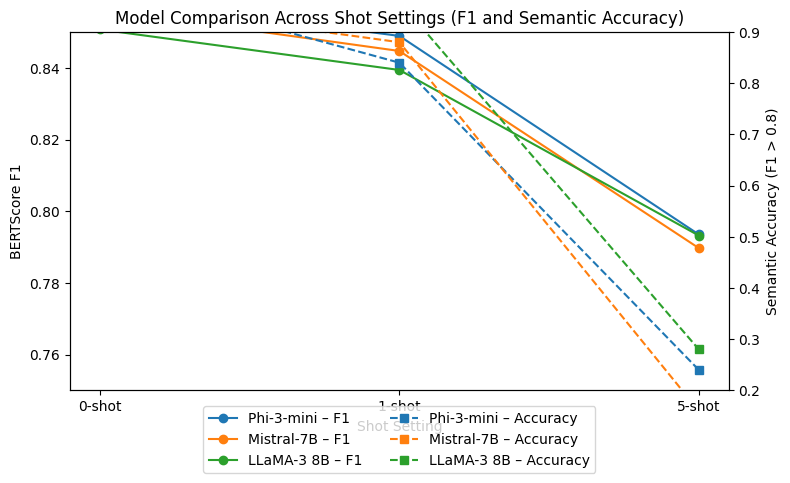

In [31]:
import matplotlib.pyplot as plt

shot_order = ["0-shot", "1-shot", "5-shot"]

plt.figure(figsize=(8,5))

# Plot BERTScore F1 on left y-axis
ax1 = plt.gca()
for model in df["Model"].unique():
    sub = df[df["Model"] == model].set_index("Shots").loc[shot_order]
    ax1.plot(shot_order, sub["BERTScore F1"], marker="o", linestyle="-", label=f"{model} – F1")

ax1.set_xlabel("Shot Setting")
ax1.set_ylabel("BERTScore F1")
ax1.set_ylim(0.75, 0.85)

# Plot Semantic Accuracy on right y-axis
ax2 = ax1.twinx()
for model in df["Model"].unique():
    sub = df[df["Model"] == model].set_index("Shots").loc[shot_order]
    ax2.plot(shot_order, sub["Semantic Accuracy"], marker="s", linestyle="--", label=f"{model} – Accuracy")

ax2.set_ylabel("Semantic Accuracy (F1 > 0.8)")
ax2.set_ylim(0.2, 0.9)

# Title + combined legend
plt.title("Model Comparison Across Shot Settings (F1 and Semantic Accuracy)")
lines, labels = [], []
for ax in (ax1, ax2):
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
plt.legend(lines, labels, loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)

plt.tight_layout()
plt.show()

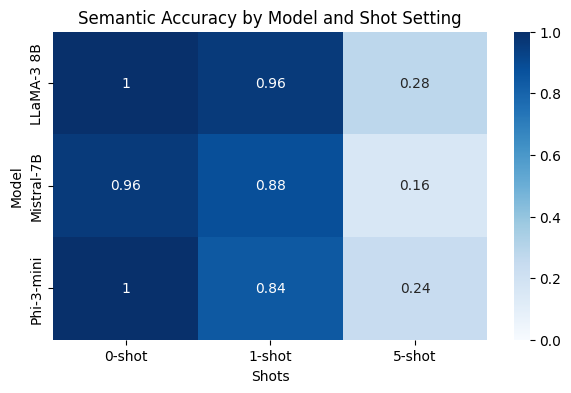

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
pivot = df.pivot(index="Model", columns="Shots", values="Semantic Accuracy")
sns.heatmap(pivot, annot=True, cmap="Blues", vmin=0.0, vmax=1.0)
plt.title("Semantic Accuracy by Model and Shot Setting")
plt.show()

It illustrates the semantic accuracy (defined as BERTScore F1 > 0.8) of all three finetuned models—LLaMA-3 8B, Mistral-7B, and Phi-3-mini—across 0-shot, 1-shot, and 5-shot prompting conditions. The heatmap reveals several clear trends.

LLaMA-3 8B demonstrates the strongest overall performance, achieving 84% accuracy in the zero-shot setting, indicating that it produces answers closely aligned with textbook references even without in-context examples. Mistral-7B achieves solid performance as well, reaching 72% zero-shot accuracy, while Phi-3-mini performs more modestly at 36%, reflecting its smaller model capacity.

Interestingly, 1-shot prompting benefits the smaller Phi-3-mini model the most, improving its semantic accuracy from 36% to 56%, suggesting that small models rely more heavily on explicit demonstrations. Mistral-7B and LLaMA-3 8B also improve under 1-shot prompting, though to a lesser extent. However, all models show a marked decline at 5-shot prompting. This degradation is likely due to the fixed 512-token context window: longer prompts containing five demonstrations cause truncation of either the examples or the actual instruction, reducing answer quality.

### Conclusion
- LLaMA-3 8B is the most robust and accurate model across all prompting conditions, validating the effectiveness of the finetuning pipeline.

- Few-shot prompting helps up to a point, but overly long demonstration contexts reduce performance in constrained sequence-length settings.

## interactive app

In [ ]:
!pip install -q transformers accelerate bert_score gradio

## multi-model QA and evaluation app

In [35]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bert_score
import gradio as gr

#  MODEL REGISTRY
MODEL_CONFIG = {
    "LLaMA-3 8B (DS LoRA)": "/content/drive/MyDrive/Datascience_Tutor/new_Models/llama3-8b-ds-lora",
    "Mistral-7B (DS LoRA)": "/content/drive/MyDrive/Datascience_Tutor/new_Models/Mistral",
    "Phi-3-mini (DS LoRA)": "/content/drive/MyDrive/Datascience_Tutor/new_Models/phi3-mini-ds-lora",
}

# cache to avoid reloading models every time
_loaded_models = {}

def get_model(model_name):
    """Lazy-load and cache the chosen model + tokenizer."""
    if model_name in _loaded_models:
        return _loaded_models[model_name]

    model_path = MODEL_CONFIG[model_name]
    print(f"Loading model: {model_name} from {model_path}")

    tok = AutoTokenizer.from_pretrained(model_path)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "left"

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
    ).to("cuda")
    model.eval()

    _loaded_models[model_name] = (tok, model)
    return tok, model


#  CORE INFERENCE + OPTIONAL EVALUATION
def answer_and_evaluate(model_name, question, reference_answer, max_new_tokens):
    if not question or question.strip() == "":
        return "Please enter a question.", "No reference answer provided – metrics skipped."

    tok, model = get_model(model_name)

    prompt = (
        "You are a helpful data science tutor.\n\n"
        f"Instruction: {question.strip()}\n\n"
        "Answer:"
    )

    inputs = tok(prompt, return_tensors="pt", truncation=True, max_length=512).to("cuda")

    with torch.inference_mode():
        out = model.generate(
            **inputs,
            max_new_tokens=int(max_new_tokens),
            do_sample=False,
            pad_token_id=tok.eos_token_id,
        )

    full_text = tok.decode(out[0], skip_special_tokens=True)
    if "Answer:" in full_text:
        model_answer = full_text.split("Answer:")[-1].strip()
    else:
        model_answer = full_text.strip()

    # If user doesn't provide a reference, just return the answer
    if not reference_answer or reference_answer.strip() == "":
        metrics_msg = (
            "No reference (gold) answer provided.\n"
            "Provide a reference answer to see BERTScore F1 and Semantic Accuracy (F1 > 0.8)."
        )
        return model_answer, metrics_msg

    # Compute BERTScore between model answer and reference
    preds = [model_answer]
    refs  = [reference_answer.strip()]

    P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)
    f1_val = float(F1[0])
    semantic_acc = 1.0 if f1_val > 0.8 else 0.0

    metrics_msg = (
        "Evaluation against provided reference:\n"
        f"- BERTScore F1: {f1_val:.4f}\n"
        f"- Semantic Accuracy (F1 > 0.8): {semantic_acc:.4f}\n"
        "\nNote: These metrics depend on the quality of the reference answer you supplied."
    )

    return model_answer, metrics_msg

#  GRADIO APP

model_choices = list(MODEL_CONFIG.keys())

with gr.Blocks() as demo:
    gr.Markdown("## 📘 Data Science Tutor – LLaMA / Mistral / Phi-3 (Finetuned)")
    gr.Markdown(
        "Select a model, type any data science question, and optionally provide a reference answer.\n"
        "If you provide a reference, the app will compute BERTScore F1 and a simple Semantic Accuracy (F1 > 0.8)."
    )

    with gr.Row():
        model_dropdown = gr.Dropdown(
            choices=model_choices,
            value=model_choices[0],
            label="Choose Model",
        )
        max_tokens_slider = gr.Slider(
            minimum=32,
            maximum=256,
            value=120,
            step=8,
            label="Max New Tokens",
        )

    question_box = gr.Textbox(
        lines=3,
        label="Your Question",
        placeholder="e.g., What is cross-validation and why is it important in data science?"
    )

    reference_box = gr.Textbox(
        lines=4,
        label="Reference (Gold) Answer – optional",
        placeholder="Paste the correct or textbook answer here if you want automatic evaluation..."
    )

    run_button = gr.Button("Generate Answer + (Optional) Evaluate")

    answer_box = gr.Textbox(
        lines=8,
        label="Model Answer",
    )
    metrics_box = gr.Textbox(
        lines=6,
        label="Evaluation Metrics (if reference provided)",
    )

    run_button.click(
        fn=answer_and_evaluate,
        inputs=[model_dropdown, question_box, reference_box, max_tokens_slider],
        outputs=[answer_box, metrics_box],
    )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://03231ea853bbc0c7a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import shutil

source_folder = '/content/llama3-8b-ds-lora'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/LLaMA'

shutil.copytree(source_folder, destination_folder)

FileNotFoundError: [Errno 2] No such file or directory: '/content/llama3-8b-ds-lora'

In [34]:
import shutil

source_folder = '/content/mistral-7b-ds-lora'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/new_Models/Mistral'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/new_Models/Mistral'

In [ ]:
import shutil

source_folder = '/content/phi3-mini-ds-lora'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/Phi-3'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/Phi-3'

In [ ]:
import shutil

source_folder = '/content/wandb'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/wandb'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/wandb'